# Genomic

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import gzip
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
## importing the phenotype dataset

cl = pd.read_csv('miller2005_public_miller2005_public_clinicalMatrix.gz', compression='gzip',delimiter="\t", header=0 )
cl.head()

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91


In [3]:
## importing the genomicMAtrix dataset

gene = pd.read_csv('miller2005_public_miller2005_genomicMatrix.gz', compression='gzip',delimiter="\t", header=0 )
gene.head()

,probe,X100B08,X101B88,X102B06,X103B41,X104B91,X105B13,X106B55,X10B88,X110B34,...,X85A03,X86A40,X87A79,X88A67,X8B87,X90A63,X94A16,X96A21,X99A50,X9B52
0,211050_x_at,-0.606098,-0.712117,-0.249024,0.473394,-0.549072,-0.309201,0.418973,-0.394657,-0.472516,...,0.194257,-0.014784,0.134075,-0.199902,0.118920,-0.379270,0.820076,-0.045577,-0.024553,0.270666
1,220399_at,0.297762,0.108554,0.529916,-0.023698,-0.240675,-0.186095,0.002805,-0.131806,0.113295,...,0.158997,0.228585,-1.618250,-0.237390,0.228423,-0.433717,-1.760925,0.290775,0.248707,-0.022792
2,202115_s_at,-0.020720,-0.329813,-0.455560,0.335867,0.091474,-0.064934,0.232192,-0.024533,0.390957,...,0.611860,0.303448,0.073593,-0.082835,0.133630,0.055395,0.071154,-0.114437,0.242833,0.218242
3,224501_at,0.019116,-0.508560,0.056202,-0.011279,0.189046,0.696562,0.192982,-0.319991,-0.243859,...,0.209864,0.215092,-0.323448,-0.020308,0.214315,0.212823,0.368002,0.207986,0.267993,0.791909
4,227347_x_at,0.217003,0.750269,0.469504,-0.182406,-0.472260,0.294003,0.147632,0.462857,0.781625,...,-0.792750,0.744523,0.156747,-0.060445,0.107039,-0.192824,0.030753,-0.463569,0.116094,-0.142529


In [4]:
## transpose the dataset to have the features as columns

new_gene = gene.set_index('probe').T.rename_axis('sampleID').reset_index()
new_gene

probe,sampleID,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,216922_x_at,208331_at,211461_at,232402_at,207647_at,207646_s_at,207916_at,202829_s_at,214950_at,208164_s_at
0,X100B08,-0.606098,0.297762,-0.020720,0.019116,0.217003,-0.959766,0.319060,0.267431,0.054625,...,0.585269,0.677886,0.294886,0.334739,-0.922423,0.525822,0.655930,-0.373383,0.533709,0.955100
1,X101B88,-0.712117,0.108554,-0.329813,-0.508560,0.750269,-0.739374,-0.635076,0.404148,0.553476,...,0.343490,-0.377170,-0.146836,-0.027103,0.108189,-0.108456,0.800626,0.047387,-0.630866,0.550008
2,X102B06,-0.249024,0.529916,-0.455560,0.056202,0.469504,0.436696,0.253222,0.236894,0.263844,...,-1.192292,-0.264924,-0.403073,-0.273291,0.408303,0.256424,0.052404,-0.076766,0.170939,-0.016254
3,X103B41,0.473394,-0.023698,0.335867,-0.011279,-0.182406,0.913891,0.134585,0.468412,0.508557,...,0.233813,-0.182134,-0.132613,0.314508,0.147834,-0.766659,-1.517961,0.487872,0.394624,0.440938
4,X104B91,-0.549072,-0.240675,0.091474,0.189046,-0.472260,1.184845,0.204097,0.397236,0.107320,...,-0.063716,-0.051118,-0.149773,-0.304061,-1.229899,-0.000545,0.574513,0.597032,0.196972,0.120323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,X90A63,-0.379270,-0.433717,0.055395,0.212823,-0.192824,0.971321,-0.620542,-0.300075,-0.227528,...,-0.206234,-0.513839,-0.401776,-0.095711,-0.100813,-1.245132,-1.202338,0.419989,0.774586,0.810731
247,X94A16,0.820076,-1.760925,0.071154,0.368002,0.030753,1.839521,-0.131311,-0.134719,-0.088519,...,0.158520,-0.533802,0.656851,-0.550142,1.029998,0.569329,-0.975293,-0.121131,0.291052,-0.603854
248,X96A21,-0.045577,0.290775,-0.114437,0.207986,-0.463569,-0.695891,-0.275499,-0.617247,-0.927063,...,-0.176975,0.228833,0.444697,0.008805,0.853332,-0.181494,0.375052,-0.038691,-0.111655,1.093266
249,X99A50,-0.024553,0.248707,0.242833,0.267993,0.116094,-1.021428,-0.333262,-0.003596,-0.020699,...,-1.343960,0.001666,0.222738,0.291546,0.130782,-1.347966,-0.827747,-0.286596,0.225008,0.760187


In [5]:
# Merge the DSS column to the genomics dataset
# Use the sampleID from booth datasets for the merging

DSS = cl[['sampleID', 'DSS.time']]
DSS

,sampleID,DSS.time
0,X100B08,12.0
1,X101B88,12.0
2,X102B06,12.0
3,X103B41,NaN
4,X104B91,4.0
...,...,...
246,X90A63,3.0
247,X94A16,NaN
248,X96A21,0.0
249,X99A50,11.0


In [6]:
merged =pd.merge(new_gene,DSS, on='sampleID')
merged

,sampleID,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,208331_at,211461_at,232402_at,207647_at,207646_s_at,207916_at,202829_s_at,214950_at,208164_s_at,DSS.time
0,X100B08,-0.606098,0.297762,-0.020720,0.019116,0.217003,-0.959766,0.319060,0.267431,0.054625,...,0.677886,0.294886,0.334739,-0.922423,0.525822,0.655930,-0.373383,0.533709,0.955100,12.0
1,X101B88,-0.712117,0.108554,-0.329813,-0.508560,0.750269,-0.739374,-0.635076,0.404148,0.553476,...,-0.377170,-0.146836,-0.027103,0.108189,-0.108456,0.800626,0.047387,-0.630866,0.550008,12.0
2,X102B06,-0.249024,0.529916,-0.455560,0.056202,0.469504,0.436696,0.253222,0.236894,0.263844,...,-0.264924,-0.403073,-0.273291,0.408303,0.256424,0.052404,-0.076766,0.170939,-0.016254,12.0
3,X103B41,0.473394,-0.023698,0.335867,-0.011279,-0.182406,0.913891,0.134585,0.468412,0.508557,...,-0.182134,-0.132613,0.314508,0.147834,-0.766659,-1.517961,0.487872,0.394624,0.440938,NaN
4,X104B91,-0.549072,-0.240675,0.091474,0.189046,-0.472260,1.184845,0.204097,0.397236,0.107320,...,-0.051118,-0.149773,-0.304061,-1.229899,-0.000545,0.574513,0.597032,0.196972,0.120323,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,X90A63,-0.379270,-0.433717,0.055395,0.212823,-0.192824,0.971321,-0.620542,-0.300075,-0.227528,...,-0.513839,-0.401776,-0.095711,-0.100813,-1.245132,-1.202338,0.419989,0.774586,0.810731,3.0
247,X94A16,0.820076,-1.760925,0.071154,0.368002,0.030753,1.839521,-0.131311,-0.134719,-0.088519,...,-0.533802,0.656851,-0.550142,1.029998,0.569329,-0.975293,-0.121131,0.291052,-0.603854,NaN
248,X96A21,-0.045577,0.290775,-0.114437,0.207986,-0.463569,-0.695891,-0.275499,-0.617247,-0.927063,...,0.228833,0.444697,0.008805,0.853332,-0.181494,0.375052,-0.038691,-0.111655,1.093266,0.0
249,X99A50,-0.024553,0.248707,0.242833,0.267993,0.116094,-1.021428,-0.333262,-0.003596,-0.020699,...,0.001666,0.222738,0.291546,0.130782,-1.347966,-0.827747,-0.286596,0.225008,0.760187,11.0


In [7]:
# there are missing values 

merged = merged.dropna(axis=0)
merged


,sampleID,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,208331_at,211461_at,232402_at,207647_at,207646_s_at,207916_at,202829_s_at,214950_at,208164_s_at,DSS.time
0,X100B08,-0.606098,0.297762,-0.020720,0.019116,0.217003,-0.959766,0.319060,0.267431,0.054625,...,0.677886,0.294886,0.334739,-0.922423,0.525822,0.655930,-0.373383,0.533709,0.955100,12.0
1,X101B88,-0.712117,0.108554,-0.329813,-0.508560,0.750269,-0.739374,-0.635076,0.404148,0.553476,...,-0.377170,-0.146836,-0.027103,0.108189,-0.108456,0.800626,0.047387,-0.630866,0.550008,12.0
2,X102B06,-0.249024,0.529916,-0.455560,0.056202,0.469504,0.436696,0.253222,0.236894,0.263844,...,-0.264924,-0.403073,-0.273291,0.408303,0.256424,0.052404,-0.076766,0.170939,-0.016254,12.0
4,X104B91,-0.549072,-0.240675,0.091474,0.189046,-0.472260,1.184845,0.204097,0.397236,0.107320,...,-0.051118,-0.149773,-0.304061,-1.229899,-0.000545,0.574513,0.597032,0.196972,0.120323,4.0
5,X105B13,-0.309201,-0.186095,-0.064934,0.696562,0.294003,-0.921591,-1.488587,0.476116,0.844849,...,-0.375298,-0.126434,-0.522002,-0.202992,0.404424,-1.473320,-0.123029,0.186654,0.001976,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,X8B87,0.118920,0.228423,0.133630,0.214315,0.107039,-0.714932,0.670275,0.127405,0.252069,...,0.433971,0.091438,0.422775,0.469442,0.212320,-1.030358,-0.218450,0.308364,0.787785,11.0
246,X90A63,-0.379270,-0.433717,0.055395,0.212823,-0.192824,0.971321,-0.620542,-0.300075,-0.227528,...,-0.513839,-0.401776,-0.095711,-0.100813,-1.245132,-1.202338,0.419989,0.774586,0.810731,3.0
248,X96A21,-0.045577,0.290775,-0.114437,0.207986,-0.463569,-0.695891,-0.275499,-0.617247,-0.927063,...,0.228833,0.444697,0.008805,0.853332,-0.181494,0.375052,-0.038691,-0.111655,1.093266,0.0
249,X99A50,-0.024553,0.248707,0.242833,0.267993,0.116094,-1.021428,-0.333262,-0.003596,-0.020699,...,0.001666,0.222738,0.291546,0.130782,-1.347966,-0.827747,-0.286596,0.225008,0.760187,11.0


## SPLITTING INTO TRAIN AND TEST SETS


In [8]:
# get features and target for prediction

X = merged.drop(["sampleID", "DSS.time"], axis=1)
y = merged["DSS.time"]

# 70% training 30% testing

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


# Pipelines

In [9]:
from sklearn.pipeline import Pipeline

## baseline models

xg_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('xg', xgb.XGBRegressor())
    ]
)
knn_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('knn', neighbors.KNeighborsRegressor())
    ]
)
svr_pipe= Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ]
)

In [10]:
# list  and dictionary of pipelines for easy reference

pipelines = [xg_pipe, knn_pipe, svr_pipe]
pipe_dict = {0: 'XGBoost', 1:'KNN', 2:'SVR'}

In [11]:
## fit models

for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
xg_pred = pipelines[0].predict(X_test)
knn_pred = pipelines[1].predict(X_test)
svr_pred = pipelines[2].predict(X_test)

In [12]:
# XGBoost

xg_rmse = sqrt(mean_squared_error(y_test,xg_pred))
xg_r2 = r2_score(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
print ('R Squared =',xg_r2)
print ('MAE =',xg_mae)
print ('RMSE =',xg_rmse)

R Squared = 0.03564868501269458
MAE = 2.971012857598318
RMSE = 3.641621729283894


In [13]:
## KNN

knn_rmse = sqrt(mean_squared_error(y_test,knn_pred))
r2 = r2_score(y_test, knn_pred)
mae = mean_absolute_error(y_test, knn_pred)
print ('R Squared =',r2)
print ('MAE =',mae)
print ('RMSE =',knn_rmse)

R Squared = -0.18963561351374714
MAE = 3.0535211267605638
RMSE = 4.044680039226627


In [14]:
# SVR

svr_rmse = sqrt(mean_squared_error(y_test,svr_pred))
svr_r2 = r2_score(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
print ('R Squared =',svr_r2)
print ('MAE =',svr_mae)
print ('RMSE =',svr_rmse)

R Squared = -0.19427500573102519
MAE = 2.7479522218305554
RMSE = 4.052559173589277


# PCA

In [15]:
from sklearn.decomposition import PCA

## models with PCA

xg1_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('xg', xgb.XGBRegressor())
    ]
)
knn1_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('knn', neighbors.KNeighborsRegressor())
    ]
)
svr1_pipe= Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('svr', SVR())
    ]
)

In [16]:
# list  and dictionary of pipelines for easy reference

pipelines1 = [xg1_pipe, knn1_pipe, svr1_pipe]
pipe_dict1 = {0: 'XGBoost', 1:'KNN', 2:'SVR'}

In [17]:
## fit models

for pipe1 in pipelines1:
    pipe1.fit(X_train, y_train)
    
xg1_pred = pipelines1[0].predict(X_test)
knn1_pred = pipelines1[1].predict(X_test)
svr1_pred = pipelines1[2].predict(X_test)

In [18]:
# XGBoost with pca

xg1_rmse = sqrt(mean_squared_error(y_test,xg1_pred))
xg1_r2 = r2_score(y_test, xg1_pred)
xg1_mae = mean_absolute_error(y_test, xg1_pred)
print ('R Squared =',xg1_r2)
print ('MAE =',xg1_mae)
print ('RMSE =',xg1_rmse)

R Squared = -0.447797477355784
MAE = 3.3809512198810845
RMSE = 4.462015772058713


In [19]:
# knn with pca

knn1_rmse = sqrt(mean_squared_error(y_test,knn_pred))
knn1_r2 = r2_score(y_test, knn_pred)
knn1_mae = mean_absolute_error(y_test, knn_pred)
print ('R Squared =',knn1_r2)
print ('MAE =',knn1_mae)
print ('RMSE =',knn1_rmse)

R Squared = -0.18963561351374714
MAE = 3.0535211267605638
RMSE = 4.044680039226627


In [20]:
# svr with pca

svr1_rmse = sqrt(mean_squared_error(y_test,svr1_pred))
svr1_r2 = r2_score(y_test, svr1_pred)
svr1_mae = mean_absolute_error(y_test, svr1_pred)
print ('R Squared =',svr1_r2)
print ('MAE =',svr1_mae)
print ('RMSE =',svr1_rmse)

R Squared = -0.2090832125715547
MAE = 2.788507452285391
RMSE = 4.077606275048595


# Results

In [21]:
## all attributes

algo = pd.DataFrame(index=["R Squared", "MAE", "RMSE"],
                   columns=["XGB Regressor", "KNRegressor", "SVR"])

algo.loc["R Squared", "XGB Regressor"] = xg_r2
algo.loc["MAE", "XGB Regressor"] = xg_mae
algo.loc["RMSE", "XGB Regressor"] = xg_rmse

algo.loc["R Squared", "KNRegressor"] = r2
algo.loc["MAE", "KNRegressor"] = mae
algo.loc["RMSE", "KNRegressor"] = knn_rmse

algo.loc["R Squared", "SVR"] = svr_r2
algo.loc["MAE", "SVR"] = svr_mae
algo.loc["RMSE", "SVR"] = svr_rmse




In [22]:
algo

,XGB Regressor,KNRegressor,SVR
R Squared,0.035649,-0.189636,-0.194275
MAE,2.971013,3.053521,2.747952
RMSE,3.641622,4.04468,4.052559


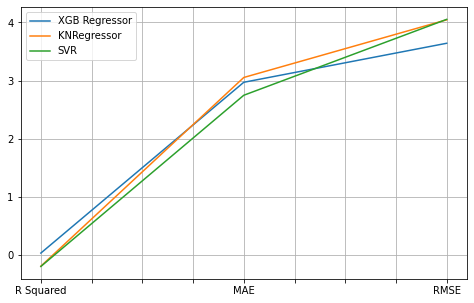

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
algo.plot(kind='line', ax=ax)
ax.grid();

In [24]:
## pca 

algo1 = pd.DataFrame(index=["R Squared", "MAE", "RMSE"],
                   columns=["XGB Regressor", "KNRegressor", "SVR"])

algo1.loc["R Squared", "XGB Regressor"] = xg1_r2
algo1.loc["MAE", "XGB Regressor"] = xg1_mae
algo1.loc["RMSE", "XGB Regressor"] = xg1_rmse

algo1.loc["R Squared", "KNRegressor"] = knn1_r2
algo1.loc["MAE", "KNRegressor"] = knn1_mae
algo1.loc["RMSE", "KNRegressor"] = knn1_rmse

algo1.loc["R Squared", "SVR"] = svr1_r2
algo1.loc["MAE", "SVR"] = svr1_mae
algo1.loc["RMSE", "SVR"] = svr1_rmse


In [25]:
algo1

,XGB Regressor,KNRegressor,SVR
R Squared,-0.447797,-0.189636,-0.209083
MAE,3.380951,3.053521,2.788507
RMSE,4.462016,4.04468,4.077606


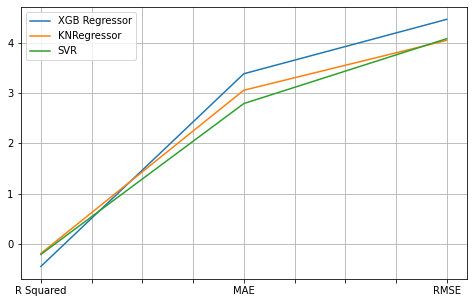

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
algo1.plot(kind='line', ax=ax)
ax.grid();